# extract arome wind data and store

10 m/s = ?? Pa = BF = 5BF = 36 km/h = 19 knts

In [1]:
import os
from glob import glob
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import cmocean.cm as cm
import cartopy.crs as ccrs

import numpy as np
import pandas as pd
import xarray as xr

----

## wind, arome

Load 2D data and extract a couple of stations

In [2]:
# deployment informations

deployments_info = {
    "2019_summer_toulon": dict(start = pd.Timestamp(2019,7,13),
                               end = pd.Timestamp(2019,7,31),
                               site = "toulon",
                               ),
    "2020_spring_toulon": dict(start = pd.Timestamp(2020,4,13),
                               end = pd.Timestamp(2020,5,12),
                               site = "toulon",
                               ),
    "2020_autumn_toulon": dict(start = pd.Timestamp(2020,10,16),
                               end = pd.Timestamp(2020,11,5),
                               site = "toulon",
                               ),
    "2021_winter_toulon": dict(start = pd.Timestamp(2020,12,11),
                               end = pd.Timestamp(2021,1,6),
                               site = "toulon",
                               ),
    "2021_spring_monaco": dict(start = pd.Timestamp(2021,4,30),
                               end = pd.Timestamp(2021,6,9),
                               site = "monaco",
                               ),
    "2022_summer_toulon": dict(start = pd.Timestamp(2022,6,3),
                               end = pd.Timestamp(2022,6,13),
                               site = "toulon",
                               ),
}

In [11]:
#
deployment = "2019_summer_toulon"
#deployment = "2020_spring_toulon"
#deployment = "2020_autumn_toulon"
#deployment = "2021_winter_toulon"
#deployment = "2021_spring_monaco"
#deployment = "2022_summer_toulon"

data_dir = f"/Users/aponte/Current_Projects/das/data/{deployment}/processed"

In [12]:
dinfo = deployments_info[deployment]

nc = os.path.join(data_dir, "wind_arome.nc")
ds = xr.open_dataset(nc)

#ds = load_arome([dinfo["start"], dinfo["end"]], dt=dt, 
#                longitude=lon, latitude=lat).chunk(dict(time="auto"))
#ds.to_netcdf(nc, mode="w")

In [13]:
ds

<xarray.Dataset>
Dimensions:    (time: 1273, latitude: 61, longitude: 81)
Coordinates:
  * time       (time) datetime64[ns] 2019-06-13 ... 2019-08-05
  * latitude   (latitude) float32 42.0 42.03 42.05 42.08 ... 43.45 43.47 43.5
  * longitude  (longitude) float32 5.0 5.025 5.05 5.075 ... 6.925 6.95 6.975 7.0
    height     float32 ...
Data variables: (12/13)
    hu2m       (time, latitude, longitude) float32 ...
    nebul      (time, latitude, longitude) float32 ...
    pmer       (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    u10m       (time, latitude, longitude) float32 ...
    v10m       (time, latitude, longitude) float32 ...
    ...         ...
    flsen      (time, latitude, longitude) float32 ...
    flsolaire  (time, latitude, longitude) float32 ...
    fltherm    (time, latitude, longitude) float32 ...
    ustress    (time, latitude, longitude) float32 ...
    vstress    (time, latitude, longitude) float32 ...
    eau        (time, latitude, longitude) float32 ...
Attributes: (12/40)
    data_type:               OCO straight grid
    format_version:          1.2
    title:                   Meteo-France Arome analysis and forecast
    Conventions:             CF-1.3
    netcdf_version:          3.5
    product_name:            METEOFRANCE_AROME_20190613T00Z.nc
    ...                      ...
    data_centre:             CD-OCO
    data_centre_references:  http://www.previmer.org/
    contact:                 cdoco-exploit@ifremer.fr
    distribution_statement:  Data restrictions: for registered users only
    operational_status:      operational
    quality_index:           1

### select points of interest

In [14]:
dinfo["site"]

'toulon'

In [15]:
# define points of interest
if dinfo["site"]=="toulon":
    lonp = [5.904, 5.904]
    latp = [43.045, 42.9]
    labels = ["nearshore", "offshore"]
elif dinfo["site"]=="monaco":
    assert False, "need to define points"

# load arome data
#ds = xr.open_dataset(os.path.join(processed_data_dir, "wind_arome.nc"))
# adjust stress such that it's not a cummulled estimate
# see https://donneespubliques.meteofrance.fr/client/document/description_parametres_modeles-arpege-arome-v2_184.pdf
ds["ustress"] = ds["ustress"]/3600
ds["vstress"] = ds["vstress"]/3600
ds["speed10m"] = np.sqrt(ds.u10m**2+ds.v10m**2)
ds["dir10m"] = np.arctan2(ds.v10m, ds.u10m)*180/np.pi
ds["stress"] = np.sqrt(ds.ustress**2+ds.vstress**2)


dsp = xr.Dataset(dict(lon=("point", lonp), lat=("point", latp)))
dsp = ds.interp(longitude=dsp.lon, latitude=dsp.lat).assign_coords(point=("point", labels))
#dsp["speed10m"] = np.sqrt(dsp.u10m**2+dsp.v10m**2)
#dsp["dir10m"] = np.arctan2(dsp.v10m, dsp.u10m)*180/np.pi
#dsp["stress"] = np.sqrt(dsp.ustress**2+dsp.vstress**2)

dsp

<xarray.Dataset>
Dimensions:    (time: 1273, point: 2)
Coordinates:
  * time       (time) datetime64[ns] 2019-06-13 ... 2019-08-05
    height     float32 0.0
    longitude  (point) float64 5.904 5.904
    latitude   (point) float64 43.05 42.9
  * point      (point) <U9 'nearshore' 'offshore'
Data variables: (12/16)
    hu2m       (time, point) float64 0.6882 0.6483 0.768 ... 0.9299 0.9313
    nebul      (time, point) float64 0.0 0.0 0.0 0.0 ... 0.0354 0.7754 0.0852
    pmer       (time, point) float64 1.015e+05 1.015e+05 ... 1.015e+05 1.015e+05
    t2m        (time, point) float64 290.4 290.9 288.1 ... 296.4 296.4 296.4
    u10m       (time, point) float64 5.17 6.94 4.45 ... -1.826 -0.8484 -1.842
    v10m       (time, point) float64 -2.04 -2.914 -2.559 ... 0.005829 -0.5083
    ...         ...
    ustress    (time, point) float64 -0.03918 -0.07236 ... 0.0008928 0.003631
    vstress    (time, point) float64 0.01602 0.02482 ... 4.867e-05 0.004129
    eau        (time, point) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    speed10m   (time, point) float64 5.559 7.527 5.135 ... 2.557 0.8495 1.911
    dir10m     (time, point) float64 -21.43 -22.78 -29.87 ... -122.4 -164.6
    stress     (time, point) float64 0.04233 0.0765 0.04552 ... 0.001021 0.0055
Attributes: (12/40)
    data_type:               OCO straight grid
    format_version:          1.2
    title:                   Meteo-France Arome analysis and forecast
    Conventions:             CF-1.3
    netcdf_version:          3.5
    product_name:            METEOFRANCE_AROME_20190613T00Z.nc
    ...                      ...
    data_centre:             CD-OCO
    data_centre_references:  http://www.previmer.org/
    contact:                 cdoco-exploit@ifremer.fr
    distribution_statement:  Data restrictions: for registered users only
    operational_status:      operational
    quality_index:           1

### store or load data from here

In [25]:
store = False

nc_pt = os.path.join(data_dir, "wind_arome_pts.nc")
if store:
    dsp.to_netcdf(nc_pt, mode="w")
else:
    dsp = xr.open_dataset(nc_pt)

### 2 points plot

Text(0.5, 1.0, 'wind stress')

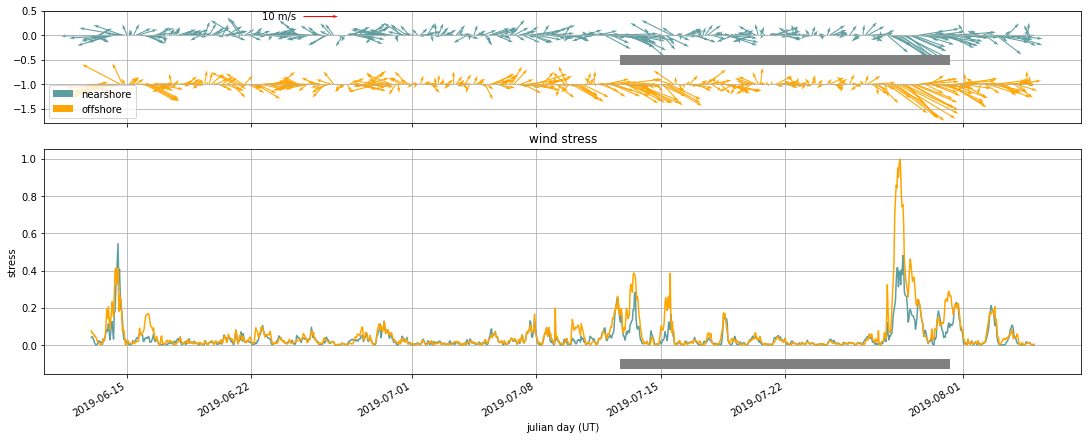

In [18]:
colors=["cadetblue", "orange"]

figsize=(15,6)

gs_kw = dict(height_ratios=[.5, 1])
fig, axd = plt.subplot_mosaic([['top'],['bottom']],
                              gridspec_kw=gs_kw, figsize=figsize,
                              constrained_layout=True, sharex=True)
# bathy
ax = axd["top"]
ax.plot([dinfo["start"], dinfo["end"]], -.5*np.ones(2), lw=10, color=".5")

di = 3
akwargs = dict(scale=3e2, width=1e-3)

off=0
for pt, c in zip(dsp.point.values, colors):
    _ds = dsp.sel(point=pt).isel(time=slice(0,None,di))
    q = ax.quiver(_ds.time,np.zeros(_ds.time.size)+off, _ds.u10m,  _ds.v10m, color=c, label=pt, **akwargs)
    off+=-1
ax.set_ylim(-1.8, .5)
ax.legend()
qk = ax.quiverkey(q, 0.25, 0.95, 10, '10 m/s', transform=ccrs.PlateCarree(), color="r",
                  labelpos='W', coordinates='axes', zorder=10)
ax.grid()

#

ax = axd["bottom"]
ax.plot([dinfo["start"], dinfo["end"]], [-.1, -.1], lw=10, color=".5")
for pt, c in zip(dsp.point.values, colors):
    dsp.sel(point=pt).stress.plot.line(x="time", ax=ax, color=c)
ax.grid()
ax.set_title("wind stress")

### 1 point plot

Text(0.5, 1.0, 'wind stress')

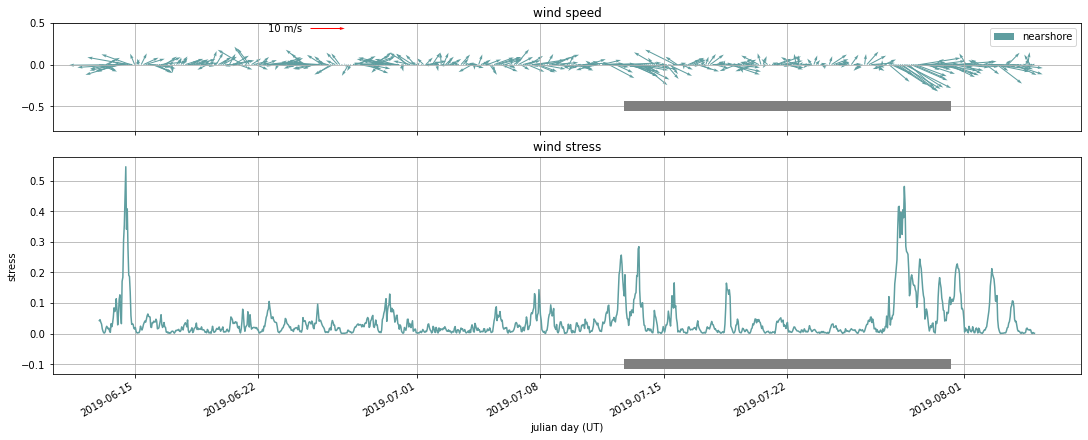

In [27]:
#colors=["cadetblue", "orange"]
colors=["cadetblue"]


_dsp = dsp.sel(point=["nearshore"])

figsize=(15,6)

gs_kw = dict(height_ratios=[.5, 1])
fig, axd = plt.subplot_mosaic([['top'],['bottom']],
                              gridspec_kw=gs_kw, figsize=figsize,
                              constrained_layout=True, sharex=True)
# wind speed
ax = axd["top"]
ax.plot([dinfo["start"], dinfo["end"]], -.5*np.ones(2), lw=10, color=".5")

di = 3
akwargs = dict(scale=3e2, width=1e-3)

off=0
for pt, c in zip(_dsp.point.values, colors):
    _ds = _dsp.sel(point=pt).isel(time=slice(0,None,di))
    q = ax.quiver(_ds.time,np.zeros(_ds.time.size)+off, _ds.u10m,  _ds.v10m, color=c, label=pt, **akwargs)
    off+=-1
ax.set_ylim(-.8, .5)
ax.legend()
qk = ax.quiverkey(q, 0.25, 0.95, 10, '10 m/s', transform=ccrs.PlateCarree(), color="r",
                  labelpos='W', coordinates='axes', zorder=10)
ax.grid()
ax.set_title("wind speed")

#
ax = axd["bottom"]
ax.plot([dinfo["start"], dinfo["end"]], [-.1, -.1], lw=10, color=".5")
for pt, c in zip(_dsp.point.values, colors):
    _dsp.sel(point=pt).stress.plot.line(x="time", ax=ax, color=c)
ax.grid()
ax.set_title("wind stress")